In [1]:
import os, sys
import json
import pandas as pd
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import gensim
from gensim import corpora
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Constructed Dataset

In [2]:
path = "./data/"
all_abstracts = pd.read_csv(os.path.join(path,) + "all-abstracts-labeled.csv")
all_abstracts

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,abstract,authors,institutions,conference,date,industry
0,"""How do I fool you?"": Manipulating User Trust ...",As machine learning black boxes are increasing...,"['Himabindu Lakkaraju', 'Osbert Bastani']","['Harvard University, Cambridge, MA, USA', 'Un...",AIES '20: Proceedings of the AAAI/ACM Conferen...,February 2020,False
1,"""I Can’t Reply with That"": Characterizing Prob...","In email interfaces, providing users with repl...","['Ronald Robertson', 'Alexandra Olteanu', 'Fer...",Microsoft,CHI Conference on Human Factors in Computing S...,2021-05-01,True
2,"""Meaningful Information"" and the Right to Expl...","There is no single, neat statutory provision l...","Andrew Selbst, Julia Powles","[""Data & Society Research Institute"", ""Yale IS...",FAT* 2018,2018,False
3,"""Scary Robots"": Examining Public Responses to AI",How AI is perceived by the public can have sig...,"['Stephen Cave', 'Kate Coughlan', 'Kanta Dihal']","['University of Cambridge, Cambridge, United K...",AIES '19: Proceedings of the 2019 AAAI/ACM Con...,January 2019,False
4,"""The Global South is everywhere, but also alwa...",There is more attention than ever on the socia...,['Amba Kak'],"['AI Now Institute, New York, NY, USA']",AIES '20: Proceedings of the AAAI/ACM Conferen...,February 2020,False
...,...,...,...,...,...,...,...
602,"Whose side are ethics codes on?: power, respon...",The moral authority of ethics codes stems from...,"['Anne L. Washington', 'Rachel Kuo']","['New York University', 'New York University']",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
603,Whose tweets are surveilled for the police: an...,Social media monitoring by law enforcement is ...,"['Glencora Borradaile', 'Brett Burkhardt', 'Al...","['Oregon State University', 'Oregon State Univ...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
604,Why does my model fail?: contrastive local exp...,"In various business settings, there is an inte...","['Ana Lucic', 'Hinda Haned', 'Maarten de Rijke']","['University of Amsterdam, Amsterdam, Netherla...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,True
605,Why Reliabilism Is not Enough: Epistemic and M...,In this paper we argue that standard calls for...,"['Andrew Smart', 'Larry James', 'Ben Hutchinso...","['Google, San Francisco, CA, USA', 'Google, Sa...",AIES '20: Proceedings of the AAAI/ACM Conferen...,February 2020,True


In [3]:
path = "data/"
all_abstracts = pd.read_csv(path + "all-abstracts-labeled.csv")
all_abstracts['abstract'] = all_abstracts['abstract'].apply(lambda x: ' '.join(x.split('\n')))
industry = list(all_abstracts[all_abstracts['industry'] == True]['abstract'])
academia = list(all_abstracts[all_abstracts['industry'] == False]['abstract'])
full_dataset = industry + academia

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling

In [4]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

academia_clean = [clean(doc).split() for doc in academia]
industry_clean = [clean(doc).split() for doc in industry]
full_clean = [clean(doc).split() for doc in full_dataset]

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
academia_dict = corpora.Dictionary(academia_clean)
industry_dict = corpora.Dictionary(industry_clean)
full_dict = corpora.Dictionary(full_clean)
academia_term_matrix = [academia_dict.doc2bow(doc) for doc in academia_clean]
industry_term_matrix = [industry_dict.doc2bow(doc) for doc in industry_clean]
full_term_matrix = [full_dict.doc2bow(doc) for doc in full_clean]

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Word cloud

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


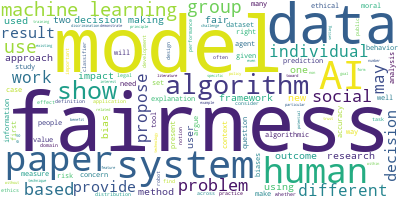

In [20]:
# Academia wordcloud
long_string = ','.join(list(academia))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_file(os.path.join("figures", "academia_cloud.png"))
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


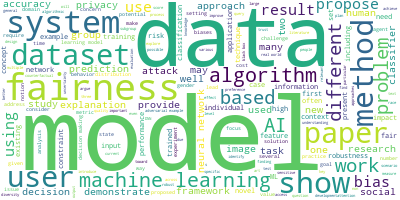

In [21]:
# Industry wordcloud
long_string = ','.join(list(industry))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_file(os.path.join("figures", "industry_cloud.png"))
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


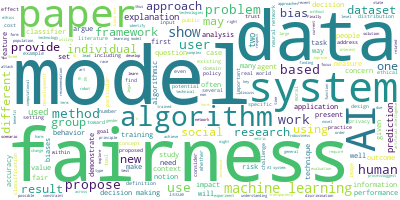

In [8]:
# Entire dataset wordcloud
long_string = ','.join(list(full_dataset))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### TF-IDF reweighting

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


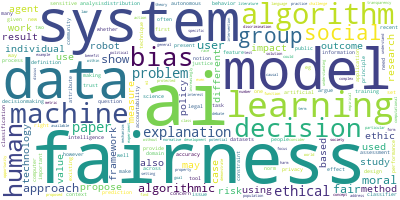

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# convert each doc to strings
academia_clean_doc = [" ".join(doc) for doc in academia_clean]
industry_clean_doc = [" ".join(doc) for doc in industry_clean]

vectorizer = TfidfVectorizer()
academia_tfidf = vectorizer.fit_transform(academia_clean_doc)
feature_names = vectorizer.get_feature_names()

academia_dense = academia_tfidf.todense()
denselist = academia_dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose().sum(axis=1)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(df)
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


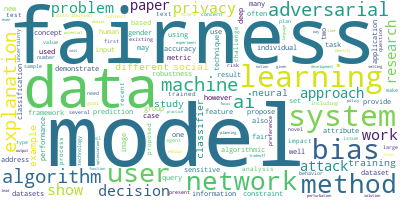

In [10]:
vectorizer = TfidfVectorizer()
industry_tfidf = vectorizer.fit_transform(industry_clean_doc)
feature_names = vectorizer.get_feature_names()

industry_dense = industry_tfidf.todense()
denselist = industry_dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose().sum(axis=1)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(df)
wordcloud.to_image()

## LDA visualization

In [21]:
from gensim.models.ldamodel import LdaModel
from gensim.models import HdpModel
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
sns.set_theme()

Perform topic visualization on entire dataset. Compare coherence for topic #s 2-5.

In [12]:
# Full Dataset
lda_models = {}
topic_range = np.arange(2, 26)
for i in topic_range:
    lda_models[i] = LdaModel(full_term_matrix, num_topics=i, id2word=full_dict, passes=50)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# get coherence of the different lda models
model_list = [lda_models[i] for i in topic_range]
cm = CoherenceModel.for_models(model_list, full_dict, corpus=full_term_matrix, coherence='u_mass')

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


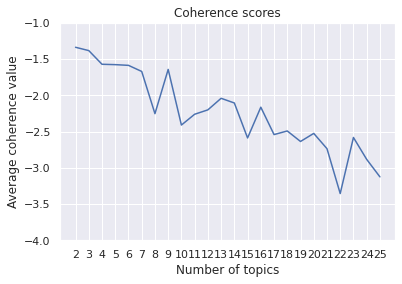

In [23]:
coherence_vals = [tup[1] for tup in cm.compare_models(model_list)]
plt.plot(np.array([i for i in topic_range]), coherence_vals)
plt.ylim(-4, -1)
plt.xticks(topic_range)
plt.xlabel("Number of topics")
plt.ylabel("Average coherence value")
plt.title("Coherence scores")
# plt.savefig("figures/coherence_topics.png")

In [24]:
lda_display = gensimvis.prepare(lda_models[14], full_term_matrix, full_dict, R=15, sort_topics=False)
# pyLDAvis.save_html(lda_display, open("./figures/lda_vis_14.html", "w"))
pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
lda_display = gensimvis.prepare(lda_models[2], full_term_matrix, full_dict, R=15, sort_topics=False)
# pyLDAvis.save_html(lda_display, open("./figures/lda_vis_2.html", "w"))
pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
hdp = HdpModel(full_term_matrix, full_dict)
alpha = hdp.hdp_to_lda()[0]
print((alpha > 0.025).sum())

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12


In [29]:
# Examine topic distribution among industry & academic papers
aca_docs = [full_dict.doc2bow(doc) for doc in academia_clean]
industry_docs = [full_dict.doc2bow(doc) for doc in industry_clean]

# for i in range(len(full_term_matrix)):
#     print(lda2.get_document_topics(full_term_matrix[i]))

# visualize in topic space
acad_pts = []
industry_pts = []
labels = []

def generate_point(topic_dist):
    primary_topic = topic_dist[0][0]
    pct_topic = topic_dist[0][1]
    point = [0, 0]
    point[primary_topic] = pct_topic
    point[1 - primary_topic] = 1 - pct_topic
    return point

for i in range(len(aca_docs)):
    topic_dist = lda_models[2].get_document_topics(aca_docs[i])
    acad_pts.append(generate_point(topic_dist))
    labels.append("Non-industry")
    
for i in range(len(industry_docs)):
    topic_dist = lda_models[2].get_document_topics(industry_docs[i])
    industry_pts.append(generate_point(topic_dist))
    labels.append("Industry")


/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
print(academia[5])
acad_pts[5]
token_id = full_dict.token2id['context']
print(lda_models[2].get_term_topics(token_id, minimum_probability=0))

The use of cash bail as a mechanism for detaining defendants pretrial is an often-criticized system that many have argued violates the presumption of "innocent until proven guilty." Many studies have sought to understand both the long-term effects of cash bail's use and the disparate rate of cash bail assignments along demographic lines (race, gender, etc). However, such work is often susceptible to problems of infra-marginality - that the data we observe can only describe average outcomes, and not the outcomes associated with the marginal decision. In this work, we address this problem by creating a hierarchical Bayesian model of cash bail assignments. Specifically, our approach models cash bail decisions as a probabilistic process whereby judges balance the relative costs of assigning cash bail with the cost of defendants potentially skipping court dates, and where these skip probabilities are estimated based upon features of the individual case. We then use Monte Carlo inference to 

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


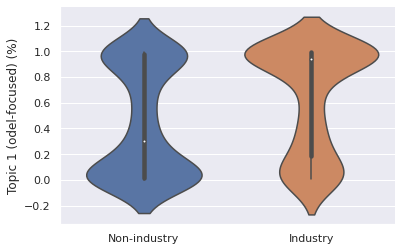

In [32]:
# restrict to topic 2
topic_1 = np.array(acad_pts + industry_pts)[:, 1]

ax = sns.violinplot(x=labels, y=topic_1)
ax.set(ylabel="Topic 1 (odel-focused) (%)")
sns.despine()
fig = ax.get_figure()
fig.savefig("figures/industry_topic.png")

In [63]:
# # Academia
# ldamodel = LdaModel(academia_term_matrix, num_topics=3, id2word=academia_dict, passes=50)
# lda_display = gensimvis.prepare(ldamodel, academia_term_matrix, academia_dict, sort_topics=False)
# pyLDAvis.display(lda_display)

# # Industry
# ldamodel = LdaModel(industry_term_matrix, num_topics=5, id2word=industry_dict, passes=50)
# lda_display = gensimvis.prepare(ldamodel, industry_term_matrix, industry_dict, sort_topics=False)
# pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Binary Classification

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_curve, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, make_scorer, balanced_accuracy_score
from sklearn.base import clone
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import xgboost as xgb
import pickle as pkl
import warnings
warnings.filterwarnings('ignore') 

xgb.set_config(verbosity=0)

In [13]:
# dataset of cleaned documents
# x_academia = [' '.join(doc) for doc in academia_clean]
x_academia = academia
y_academia = [0]*len(x_academia)
# x_industry = [' '.join(doc) for doc in industry_clean]
x_industry = industry
y_industry = [1]*len(x_industry)
X = x_academia + x_industry
y = y_academia + y_industry

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# save dataset partition
train_df = pd.DataFrame(list(zip(X_train, y_train)), columns=['text', 'industry'])
test_df = pd.DataFrame(list(zip(X_test, y_test)), columns=['text', 'industry'])
train_df.to_csv("./data/partition/train.csv", index=False)
test_df.to_csv("./data/partition/test.csv", index=False)

In [16]:
# define featurizers
featurizers = {
    "tfidf": TfidfVectorizer(),
    "bow": CountVectorizer(),
}

# define classifiers
classifiers = {
    "xgboost": xgb.XGBClassifier(objective="binary:logistic", seed=1337),
    "logistic regression": LogisticRegression(),
    "multinomial nb": MultinomialNB(),
    "svc": SVC(),
}

param_grids = {
    "logistic regression": {
        "clf__C" : [100, 10, 1, 1e-1]
    },
    "multinomial nb": {
        "clf__alpha": np.linspace(0.5, 1.5, 6),
        "clf__fit_prior": [True, False],  
    },
    "svc": {
        'clf__C': np.logspace(-1, 3, base = 10, num=4),  
        'clf__gamma': [1, 0.1, 0.01], 
    },
    "xgboost": {
        'clf__learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
        'clf__max_depth': [4, 6, 8],
        'clf__subsample': [0.6, 0.7, 0.8],
        'clf__colsample_bytree': [0.3, 0.5, 0.7],
        'clf__n_estimators': [5, 200, 400, 1000], #number of trees, change it to 1000 for better results
    }
}

scoring = {
    'acc': 'accuracy',
    'balanced_acc': 'balanced_accuracy',
    'pos_prec': 'precision',
    'pos_rec': 'recall',
    'f1': 'f1',
    'auc_roc': 'roc_auc'
}

# utils for printing performance
def mean_and_std(scores):
    """ Return string with mean & stdev"""
    arr = np.array(scores)
    return f"{arr.mean():0.4f} (SD: {arr.std():0.4f})" 

def print_scores(scores, num_folds=5):
    print()
    print("Validation statistics of best model")
    print("-----------------------")
    print(f"{num_folds}-fold CV Val Accuracy:\t\t{mean_and_std(scores['test_acc'])}")
    print(f"{num_folds}-fold CV Val Balanced Accuracy:\t\t{mean_and_std(scores['test_balanced_acc'])}")
    print(f"{num_folds}-fold CV Val Precision (Industry):\t\t{mean_and_std(scores['test_pos_prec'])}")
    print(f"{num_folds}-fold CV Val Recall (Industry):\t\t{mean_and_std(scores['test_pos_rec'])}")
    print(f"{num_folds}-fold CV Val F1:\t\t{mean_and_std(scores['test_f1'])}")
    print(f"{num_folds}-fold CV Val ROC AUC:\t\t{mean_and_std(scores['test_auc_roc'])}")
    print()
    print("Training statistics of best model")
    print("-----------------------")
    print(f"{num_folds}-fold CV Train Accuracy:\t\t{mean_and_std(scores['train_acc'])}")
    print(f"{num_folds}-fold CV Train Balanced Accuracy:\t\t{mean_and_std(scores['train_balanced_acc'])}")
    print(f"{num_folds}-fold CV Train Precision (Industry):\t\t{mean_and_std(scores['train_pos_prec'])}")
    print(f"{num_folds}-fold CV Train Recall (Industry):\t\t{mean_and_std(scores['train_pos_rec'])}")
    print(f"{num_folds}-fold CV Train F1:\t\t{mean_and_std(scores['train_f1'])}")
    print(f"{num_folds}-fold CV Train ROC AUC:\t\t{mean_and_std(scores['train_auc_roc'])}")
    print()

Training xgboost classifier using tfidf featurizer...

Validation statistics of best model
-----------------------
5-fold CV Val Accuracy:		0.6639 (SD: 0.0240)
5-fold CV Val Balanced Accuracy:		0.6206 (SD: 0.0199)
5-fold CV Val Precision (Industry):		0.6355 (SD: 0.0720)
5-fold CV Val Recall (Industry):		0.4023 (SD: 0.0438)
5-fold CV Val F1:		0.4884 (SD: 0.0280)
5-fold CV Val ROC AUC:		0.6514 (SD: 0.0333)

Training statistics of best model
-----------------------
5-fold CV Train Accuracy:		0.9995 (SD: 0.0010)
5-fold CV Train Balanced Accuracy:		0.9994 (SD: 0.0013)
5-fold CV Train Precision (Industry):		1.0000 (SD: 0.0000)
5-fold CV Train Recall (Industry):		0.9987 (SD: 0.0026)
5-fold CV Train F1:		0.9994 (SD: 0.0013)
5-fold CV Train ROC AUC:		1.0000 (SD: 0.0000)

Best CV parameters:
{'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.03, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}

Accuracy score (entire train set): 0.9917525773195877
Confusion matrix (train

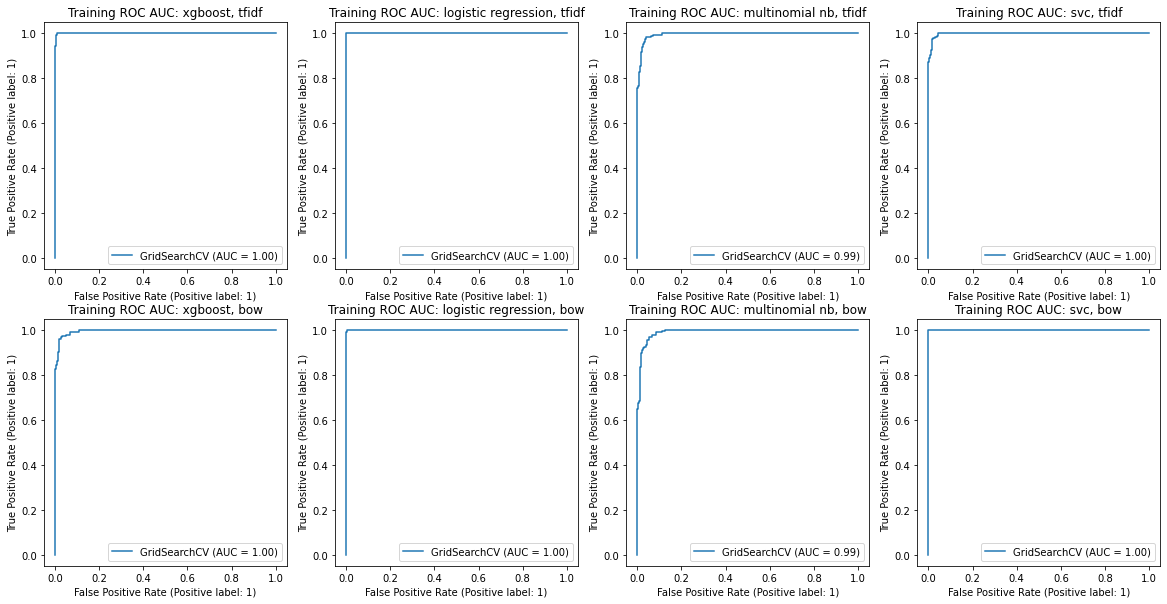

In [17]:
# refit based on highest accuracy
refit='acc'
models = {} # store best performing models

plt.figure(1, figsize=(20,10))
rows = len(featurizers)
cols = len(classifiers)
num_folds = 5
plotnum = 0
for fname, f in featurizers.items():
    for cname, c in classifiers.items():
        print(f"Training {cname} classifier using {fname} featurizer...")
        # construct pipeline of vectorizer and classifier
        pipeline = Pipeline([('vec', f),('clf', c)])
        
        # perform CV grid search
        clf = GridSearchCV(pipeline, param_grids[cname], cv=num_folds, scoring=scoring, refit=refit, return_train_score=True)
        clf.fit(X_train, y_train)
        # store fitted best model
        models[(fname, cname)] = clf
        
        # get cross validated scores for the best estimator
        scores = cross_validate(clone(clf.best_estimator_), X_train, y_train, cv=num_folds, scoring=scoring, return_train_score=True)
        print_scores(scores, num_folds=num_folds)
        print("Best CV parameters:")
        print(clf.best_params_)
        
        # plot training ROC AUC
        plotnum += 1
        ax = plt.subplot(rows, cols, plotnum)
        disp = plot_roc_curve(clf, X_train, y_train, ax=ax)
        disp.ax_.set_title(f"Training ROC AUC: {cname}, {fname}")
        
        # display metrics of interest on full training data set
        prediction = clf.predict(X_train)
        print()
        print(f"Accuracy score (entire train set): {accuracy_score(y_train, prediction)}")
        print("Confusion matrix (training set):")
        # Rows = true labels
        # Cols = predicted labels
        print(confusion_matrix(y_train, prediction))
        print()

In [ ]:
def save_models(models, filename):
    with open(filename, "wb") as file:
        pkl.dump(models, file, -1)

def load_models(filename):
    return pkl.load(open(filename, "rb"))

save_models(models, "saved_models/models_nostop.pkl")

In [18]:
# inspect logistic BOW

model = models[("tfidf", "logistic regression")].best_estimator_


feature_names = (model.named_steps['vec']
                      .get_feature_names())

coefs = pd.DataFrame(
    np.array(model.named_steps['clf'].coef_).flatten(),
    columns=['Coefficients'], index=feature_names
)

print("\nMost predictive of industry:")
print(coefs['Coefficients'].nlargest(10))

print("\nMost predictive of academia:")
print(coefs['Coefficients'].nsmallest(12))


Most predictive of industry:
dataset        2.601510
privacy        2.284450
planning       2.248793
adversarial    2.243424
preferences    2.197855
generative     2.166407
attack         2.094259
checklists     1.838190
trained        1.838130
attention      1.754164
Name: Coefficients, dtype: float64

Most predictive of academia:
ai           -3.641137
autonomous   -2.751276
ethics       -2.277021
of           -2.219570
outcomes     -2.144211
groups       -2.106342
health       -2.011810
justice      -1.982668
moral        -1.929103
the          -1.923005
population   -1.913856
that         -1.891448
Name: Coefficients, dtype: float64


In [19]:
# find highest accuracy models

# find acc_model with highest validation accuracy
name_and_models = [(k, v) for k, v in models.items()]
top_n = 4
best_acc_models = sorted(name_and_models, key=lambda tup: -1 * tup[1].best_score_)[:top_n]

for bm in best_acc_models:
    print(f"{bm[0]} validation accuracy: {bm[1].best_score_}")

('bow', 'multinomial nb') validation accuracy: 0.7237113402061857
('tfidf', 'logistic regression') validation accuracy: 0.7113402061855669
('tfidf', 'svc') validation accuracy: 0.7092783505154638
('tfidf', 'multinomial nb') validation accuracy: 0.7010309278350515


Model and featurizer: ('bow', 'multinomial nb')
Accuracy score: 0.7131147540983607
Balanced accuracy score: 0.6646959459459459
F1: 0.5454545454545455

Model and featurizer: ('tfidf', 'logistic regression')
Accuracy score: 0.7295081967213115
Balanced accuracy score: 0.6855292792792793
F1: 0.5822784810126582

Model and featurizer: ('tfidf', 'svc')
Accuracy score: 0.7295081967213115
Balanced accuracy score: 0.6782094594594594
F1: 0.56

Model and featurizer: ('tfidf', 'multinomial nb')
Accuracy score: 0.7049180327868853
Balanced accuracy score: 0.6286599099099099
F1: 0.41935483870967744



Text(0.5, 1.0, 'Test Set ROC-AUC of Final Models')

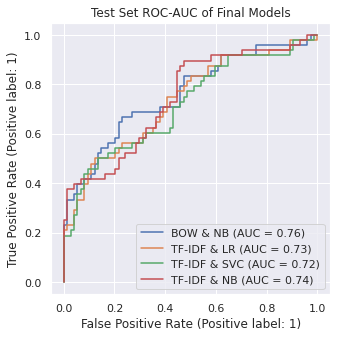

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

label_map = {
    ('bow', 'logistic regression'): 'BOW & LR',
    ('bow', 'multinomial nb'): 'BOW & NB',
    ('tfidf', 'logistic regression'): 'TF-IDF & LR',
    ('tfidf', 'multinomial nb'): 'TF-IDF & NB',
    ('tfidf', 'xgboost'): 'TF-IDF & XGBoost',
    ('tfidf', 'svc'): 'TF-IDF & SVC',
    ('bow', 'xgboost'): 'BOW & XGBoost'
}

for bm in best_acc_models:
    model = bm[1].best_estimator_
    print(f"Model and featurizer: {bm[0]}")
    
    prediction = model.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, prediction)}")
    print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, prediction)}")
    print(f"F1: {f1_score(y_test, prediction)}")
    disp = plot_roc_curve(model, X_test, y_test, ax=ax, name=label_map[bm[0]])

    print()

ax.set_title("Test Set ROC-AUC of Final Models")
# plt.savefig("figures/test_rocauc.png")